###Tahapan Implementasi
1. Pembersihan awal
2. Data Split
3. EDA
4. Preprocessing dan Augmentasi
5. Modeling (ViT)
6. Training Model
7. Visualisasi
8. Pengetesan Model

###1. Pembersihan awal


Tahap awal ini kita melakukan pemindaian pada dataset mentahnya untuk mengetahui jumlah gambar per kelas dan mengecek apakah terdapat integritas file (gambar rusak atau buram)

Kualitas data menentukan kualitas model. Maka dari itu perlu dilakukan tahap ini agar gambar atau data yang di baca akan menghasilkan keluaran yang diharapkan

=== TAHAP 1: INVENTARISASI DATA AWAL ===
        Motif Batik  Jumlah Awal
       batik_betawi          150
batik_bokor_kencono          150
      batik_buketan          150
        batik_dayak          150
    batik_jlamprang          150
       batik_kawung          150
        batik_liong          150
 batik_mega_mendung          150
       batik_parang          150
   batik_sekarjagad          150
    batik_sidoluhur          150
    batik_sidomukti          150
    batik_sidomulyo          150
 batik_singa_barong          150
     batik_srikaton          150
    batik_tribusono          150
   batik_tujuh_rupa          150
      batik_tuntrum          150
batik_wahyu_tumurun          150
      batik_wirasat          150
----------------------------------------
Total Seluruh Gambar Mentah: 3000
Total Kelas: 20
----------------------------------------

Memulai pemindaian kualitas di: /content/drive/MyDrive/DATASET/raw_dataset...


=== HASIL PEMINDAIAN KUALITAS ===
- Gambar Valid (Sia

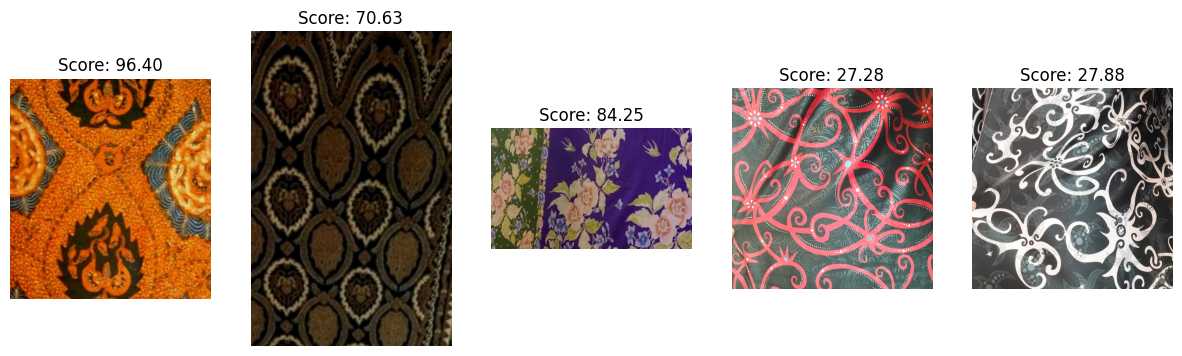

In [ ]:
import os
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# 1. Tentukan Path Dataset Mentah Anda
RAW_DATASET_PATH = '/content/drive/MyDrive/DATASET/raw_dataset'

def check_images(dataset_path, blur_threshold=100.0):
    # --- BAGIAN TAMBAHAN: INVENTARISASI DATA AWAL ---
    print("=== TAHAP 1: INVENTARISASI DATA AWAL ===")
    initial_inventory = []
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    #os.listdir untuk mendata folder
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        initial_inventory.append({'Motif Batik': cls, 'Jumlah Awal': count})

    # Tampilkan dalam bentuk tabel agar rapi
    df_initial = pd.DataFrame(initial_inventory)
    print(df_initial.to_string(index=False))
    print("-" * 40)
    print(f"Total Seluruh Gambar Mentah: {df_initial['Jumlah Awal'].sum()}")
    print(f"Total Kelas: {len(df_initial)}")
    print("-" * 40 + "\n")

    # --- TAHAP 2: PEMINDAIAN KUALITAS (CORRUPT & BLUR) ---
    corrupt_files = []
    blurry_files = []
    valid_files = 0

    print(f"Memulai pemindaian kualitas di: {dataset_path}...\n")

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # A. Cek Corrupt
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupt_files.append(img_path)
                continue

            # B. Cek Blur (Menggunakan OpenCV)
            image = cv2.imread(img_path)
            if image is None:
                corrupt_files.append(img_path)
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            #cv2.Laplacian untuk mendeteksi tingkat ketajaman gambar
            if laplacian_var < blur_threshold:
                blurry_files.append((img_path, laplacian_var))
            else:
                valid_files += 1

    return corrupt_files, blurry_files, valid_files

# Jalankan Fungsi
corrupt, blurry, valid = check_images(RAW_DATASET_PATH)

# TAMPILKAN HASIL AKHIR PEMINDAIAN
print(f"\n=== HASIL PEMINDAIAN KUALITAS ===")
print(f"- Gambar Valid (Siap Digunakan): {valid}")
print(f"- Gambar Corrupt (Rusak): {len(corrupt)}")
print(f"- Gambar Blur (Buram): {len(blurry)}")

# Tampilkan Sampel Gambar Blur jika ada
if blurry:
    print("\n--- SAMPEL GAMBAR TERDETEKSI BLUR ---")
    plt.figure(figsize=(15, 5))
    for i, (path, score) in enumerate(blurry[:5]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis('off')
    plt.show()

###2. Data Splitting

Tahapan kedua adalah memisahkan antara Data Train, Validation dan Test. Dimana pembagian ini dibagi menjadi 80-10-10, pembagian ini dilakukan agar data yang di gunakan untuk validasi dan test tidak terkontaminasi oleh data data lain yang tidak cocok untuk dilakukan pada akhir dan untuk hasil yang diharapkan.

Sebelum dilakukannya split kita melakukan penghapusan data yang blur agar tidak mempengaruhi hasil di akhir nanti, dan data yang di masukan pada semua pembagian (train, test, dan val) data yang bersih.

In [ ]:
import shutil

# 1. MENGHAPUS FILE BERMASALAH (CORRUPT & BLUR)
print("Membersihkan file bermasalah...")
files_to_remove = corrupt + [path for path, score in blurry]

for file_path in files_to_remove:
    if os.path.exists(file_path):
        os.remove(file_path)

print(f"Berhasil menghapus {len(files_to_remove)} file.")

# 2. INSTALASI LIBRARY SPLIT-FOLDERS
!pip install split-folders

# 3. PROSES SPLIT DATA (80-10-10)
import splitfolders

input_folder = RAW_DATASET_PATH # 'raw_dataset'
output_folder = 'dataset_batik_final'

splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.8, .1, .1),
                   group_prefix=None, move=False) # move=False agar data asli tetap ada

print(f"\nProses Split Selesai!")
print(f"Cek folder '{output_folder}' untuk melihat hasilnya.")

# 4. VERIFIKASI JUMLAH KELAS
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_folder, split)
    num_classes = len(os.listdir(split_path))
    print(f"Jumlah kelas di folder {split}: {num_classes}")

Membersihkan file bermasalah...
Berhasil menghapus 51 file.


Copying files: 2949 files [00:17, 169.02 files/s]


Proses Split Selesai!
Cek folder 'dataset_batik_final' untuk melihat hasilnya.
Jumlah kelas di folder train: 20
Jumlah kelas di folder val: 20
Jumlah kelas di folder test: 20


In [ ]:
# 1. Menghitung Total File Secara Keseluruhan Setelah Pembersihan
total_after_clean = valid # Ini adalah jumlah gambar yang lolos scan di Tahap 2

print("=== VERIFIKASI DISTRIBUSI DATA PASCA-SPLIT ===")
split_summary = []

for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_folder, split)

    # Hitung total file di semua sub-folder kelas
    count = 0
    for root, dirs, files in os.walk(split_path):
        count += len(files)

    percentage = (count / total_after_clean) * 100
    split_summary.append({'Split': split, 'Total Gambar': count, 'Persentase': f"{percentage:.2f}%"})

# 2. Tampilkan dalam bentuk Tabel
df_split = pd.DataFrame(split_summary)
print(df_split.to_string(index=False))

print("-" * 45)
print(f"Total Dataset yang Terbagi: {df_split['Total Gambar'].sum()}")
print("-" * 45)

# 3. Verifikasi Jumlah Kelas (Tetap dipertahankan dari kode sebelumnya)
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_folder, split)
    num_classes = len([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    print(f"Verifikasi: Folder '{split}' memiliki {num_classes} kelas.")

=== VERIFIKASI DISTRIBUSI DATA PASCA-SPLIT ===
Split  Total Gambar Persentase
train          2354     79.82%
  val           285      9.66%
 test           310     10.51%
---------------------------------------------
Total Dataset yang Terbagi: 2949
---------------------------------------------
Verifikasi: Folder 'train' memiliki 20 kelas.
Verifikasi: Folder 'val' memiliki 20 kelas.
Verifikasi: Folder 'test' memiliki 20 kelas.


###3. Exploratory Data Analysis (EDA)

Membuat grafik untuk melihat data per kelas dan menampilkan sampel gambar pada setiap motif batik untuk melihat apakah dataset ini seimbang (Balanced) atau tidak (Imbalance).

In [ ]:
import seaborn as sns
from PIL import Image

# 1. Definisikan Path Train
TRAIN_PATH = 'dataset_batik_final/train'

def perform_eda_train(train_path):
    train_data = []
    image_dims = []

    classes = sorted(os.listdir(train_path))

    # --- A. Mengumpulkan Data ---
    for cls in classes:
        class_path = os.path.join(train_path, cls)
        files = os.listdir(class_path)
        train_data.append({'Motif Batik': cls, 'Jumlah': len(files)})

        # Ambil sampel resolusi dari 5 gambar pertama tiap kelas
        for img_name in files[:5]:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    image_dims.append(img.size) # (width, height)
            except:
                continue

    df_train = pd.DataFrame(train_data)
    df_dims = pd.DataFrame(image_dims, columns=['Width', 'Height'])

    # --- B. Visualisasi Distribusi Kelas ---
    plt.figure(figsize=(12, 5))
    sns.barplot(data=df_train, x='Motif Batik', y='Jumlah', palette='magma')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribusi Kelas pada Data TRAIN (Setelah Pembersihan)')
    plt.show()

    print(f"\nTotal Data Train: {df_train['Jumlah'].sum()}")
    print(f"Rata-rata gambar per kelas: {df_train['Jumlah'].mean():.1f}")
    print(f"Resolusi rata-rata: {df_dims['Width'].mean():.0f}x{df_dims['Height'].mean():.0f}")

    # --- C. Visualisasi Sampel 20 Kelas (Grid 4x5) ---
    print("\nMenampilkan Sampel Visual 20 Kelas Batik:")
    plt.figure(figsize=(20, 16))
    for i, cls in enumerate(classes):
        class_path = os.path.join(train_path, cls)
        img_name = os.listdir(class_path)[0] # Ambil gambar pertama
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{cls}\n({img.shape[1]}x{img.shape[0]})", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan EDA
perform_eda_train(TRAIN_PATH)

###4.Preprocessing

Pada tahap ini adalah menyesuaikan semua gambar menjadi ukuran yang sama ya itu 224x224 agar proses pada tahap modeling semakin baiklagi. setelah itu menampilkan apakah semua data seperti train, val dan test memiliki kelas yang sama. Menampilkan nama nama kelas dari semua kelas, selanjutnya mengoptimasi performa dataset untuk memori management.

In [ ]:
import tensorflow as tf

# 1. Konfigurasi Dasar
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BASE_OUTPUT_PATH = 'dataset_batik_final'

# 2. Membuat Dataset Latihan (Train)
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE_OUTPUT_PATH, 'train'),
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

# 3. Membuat Dataset Validasi (Val)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE_OUTPUT_PATH, 'val'),
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# 4. Membuat Dataset Pengujian (Test)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE_OUTPUT_PATH, 'test'),
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# 5. Mendapatkan Nama Kelas
class_names = train_ds.class_names
print(f"\nBerhasil memuat {len(class_names)} kelas: {class_names}")

# 6. Optimasi Performa Dataset (Memory Management)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nOptimasi Dataset Selesai (Cache & Prefetch Aktif).")

# 7. Verifikasi Struktur Batch Pertama
for images, labels in train_ds.take(1):
    print(f"Bentuk batch gambar: {images.shape}") # (32, 224, 224, 3)
    print(f"Bentuk batch label: {labels.shape}")  # (32, 20)
    break

Found 2354 files belonging to 20 classes.
Found 285 files belonging to 20 classes.
Found 310 files belonging to 20 classes.

Berhasil memuat 20 kelas: ['batik_betawi', 'batik_bokor_kencono', 'batik_buketan', 'batik_dayak', 'batik_jlamprang', 'batik_kawung', 'batik_liong', 'batik_mega_mendung', 'batik_parang', 'batik_sekarjagad', 'batik_sidoluhur', 'batik_sidomukti', 'batik_sidomulyo', 'batik_singa_barong', 'batik_srikaton', 'batik_tribusono', 'batik_tujuh_rupa', 'batik_tuntrum', 'batik_wahyu_tumurun', 'batik_wirasat']

Optimasi Dataset Selesai (Cache & Prefetch Aktif).
Bentuk batch gambar: (32, 224, 224, 3)
Bentuk batch label: (32, 20)


###5. Modeling

Pada tahap ini kita melakukan implementasi model Vision Tranformer untuk menguji apakah emang cocok model ini di gunakan pada dataset batik, pada tahap modeling ini juga kita melakukan augmentasi agar model semakin bagus karena di latih oleh banyak bentuk yang berbeda dan model tidak menghapal.

In [ ]:
# 1. Pastikan library jembatan terinstal (Hanya jalankan jika belum)
# !pip install tf-keras

# 2. Import hub (karena belum dipanggil di tahap sebelumnya)
import tensorflow_hub as hub
import tf_keras as tfk

# 3. Definisikan URL Model ViT
VIT_HANDLE = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"

# 4. Membangun Lapisan Augmentasi menggunakan tfk
# Kita gunakan tfk.layers agar seragam dengan model utamanya
data_augmentation = tfk.Sequential([
    tfk.layers.RandomFlip("horizontal_and_vertical"),
    tfk.layers.RandomRotation(0.2),
    tfk.layers.RandomZoom(0.2),
    tfk.layers.RandomContrast(0.1),
], name="augmentation_layer")

# 5. Membangun Arsitektur Model Utuh
model = tfk.Sequential([
    # Input Layer
    tfk.layers.InputLayer(input_shape=IMG_SIZE + (3,)),

    # Augmentasi & Normalisasi
    data_augmentation,
    tfk.layers.Rescaling(1./255),

    # Feature Extractor ViT (Menggunakan hub)
    hub.KerasLayer(VIT_HANDLE, trainable=False, name="vit_base"),

    # Head Classifier
    tfk.layers.BatchNormalization(),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(256, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(len(class_names), activation='softmax', name="output_layer")
])

# 6. Kompilasi Model
model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Tampilkan Ringkasan Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation_layer (Sequen  (None, 224, 224, 3)       0         
 tial)                                                           
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vit_base (KerasLayer)       (None, 768)               85798656  
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               1

###6.Training

Pertama tama kita malaukan refresh pada memori yang membuat akan melepaskan kucian pada file atau struktur data yang tersisa dari percobaan sebelumnya. Setelah itu kita juga menggunakan early Stopping agar menghentikan training secara otomatis jika akurasi validasi sudah tidak meningkat lagi selama 5 epoch atau masa training.

In [ ]:
# 1. Bersihkan sesi backend untuk membuang sisa-sisa model lama di memori
tfk.backend.clear_session()

# 2. Tentukan Nama File Baru dengan format .keras (lebih stabil)
checkpoint_path = "best_batik_vit.keras"

# 3. Definisi Callbacks
callbacks = [
    tfk.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tfk.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        # Menggunakan format terbaru untuk menghindari error HDF5
        save_format="keras",
        verbose=1
    ),
    tfk.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )
]

# 4. Eksekusi Training
print(f"Memulai Proses Training... Model akan disimpan ke: {checkpoint_path}\n")
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks
)

print("\nTraining Selesai!")

Memulai Proses Training... Model akan disimpan ke: best_batik_vit.keras

Epoch 1/30
74/74 [==============================] - ETA: 0s - loss: 1.2584 - accuracy: 0.6440
Epoch 1: val_accuracy improved from -inf to 0.91228, saving model to best_batik_vit.keras
74/74 [==============================] - 61s 640ms/step - loss: 1.2584 - accuracy: 0.6440 - val_loss: 0.2968 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.9019
Epoch 2: val_accuracy improved from 0.91228 to 0.95088, saving model to best_batik_vit.keras
74/74 [==============================] - 36s 483ms/step - loss: 0.3198 - accuracy: 0.9019 - val_loss: 0.1862 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9405
Epoch 3: val_accuracy improved from 0.95088 to 0.96842, saving model to best_batik_vit.keras
74/74 [==============================] - 40s 546ms/step - loss: 0.2024 - accura

###7. Evaluasi Final

Pada tahap ini kita melihat hasil dari model menggunakan diagram dan melihat learning curve untuk mengetahui apakah hasil yang di berikan bener benar bagus atau kurang bagus serta menggunakan diagram lain untuk melihat penyebaran kesalahannya.

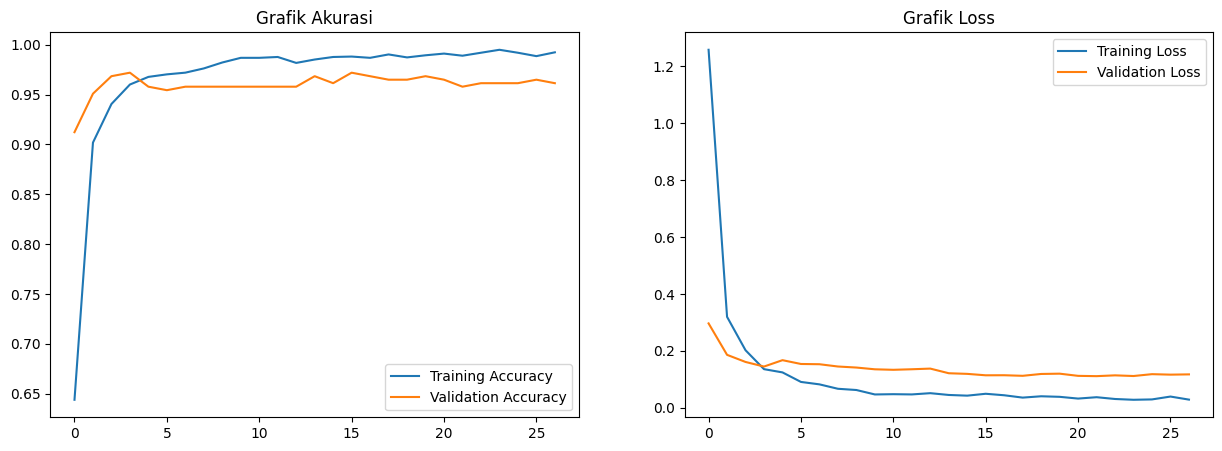


--- Evaluasi Data Test ---
10/10 [==============================] - 9s 851ms/step


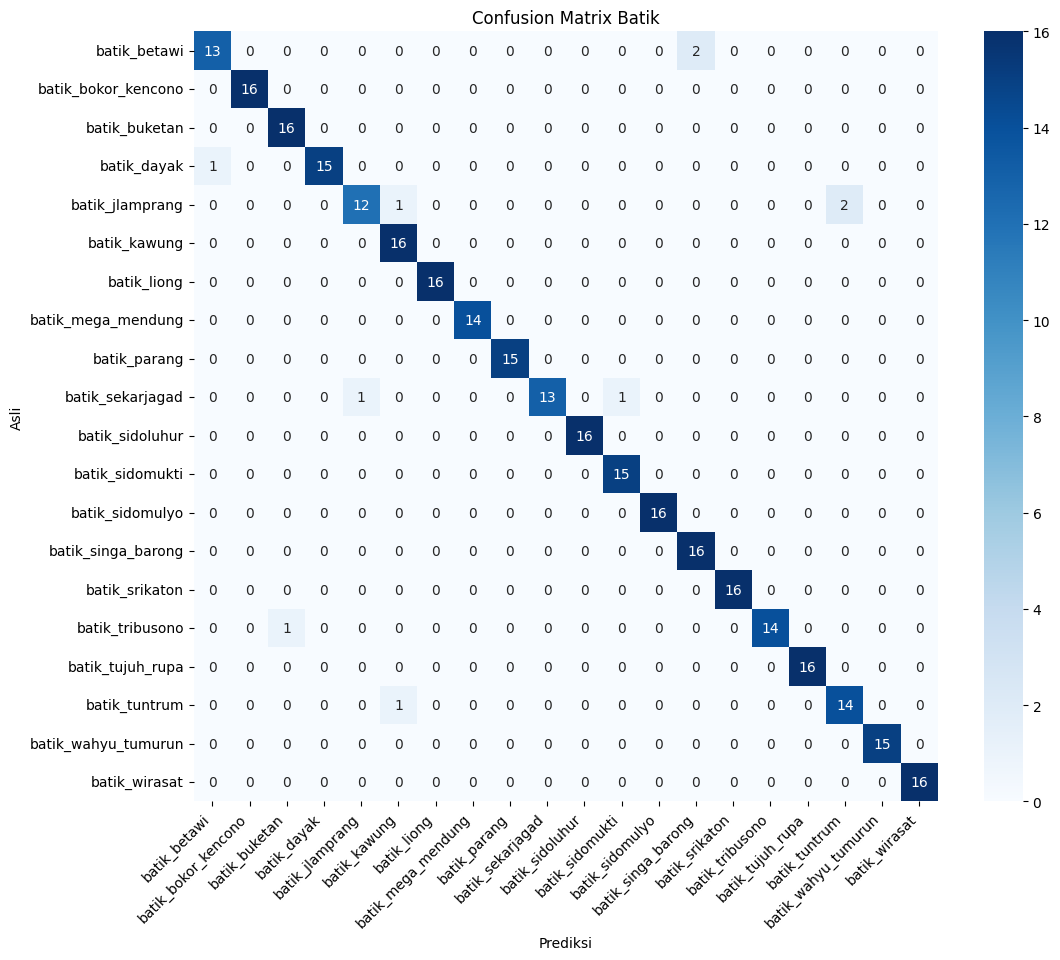


=== TABEL PERFORMA MODEL ===


,precision,recall,f1-score,support
batik_bokor_kencono,1.000000,1.000000,1.000000,16.0
batik_sidoluhur,1.000000,1.000000,1.000000,16.0
batik_liong,1.000000,1.000000,1.000000,16.0
batik_mega_mendung,1.000000,1.000000,1.000000,14.0
batik_wirasat,1.000000,1.000000,1.000000,16.0
batik_wahyu_tumurun,1.000000,1.000000,1.000000,15.0
batik_srikaton,1.000000,1.000000,1.000000,16.0
batik_parang,1.000000,1.000000,1.000000,15.0
batik_tujuh_rupa,1.000000,1.000000,1.000000,16.0
batik_sidomulyo,1.000000,1.000000,1.000000,16.0



=== RINGKASAN TOTAL ===


,precision,recall,f1-score,support
accuracy,0.967742,0.967742,0.967742,0.967742
macro avg,0.969155,0.966875,0.966927,310.000000
weighted avg,0.969244,0.967742,0.967413,310.000000


In [ ]:
# 1. Import library yang diperlukan untuk evaluasi (Hanya yang belum ada)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 2. Membuat Plot Learning Curve (Akurasi & Loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Grafik Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Grafik Loss')
plt.legend()
plt.show()

# 3. Evaluasi pada Data Test
print("\n--- Evaluasi Data Test ---")
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds], axis=0)

# 4. Visualisasi Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Batik')
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.xticks(rotation=45, ha='right')
plt.show()

# 5. Tabel Laporan Klasifikasi
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

print("\n=== TABEL PERFORMA MODEL ===")
# Menampilkan tabel hasil per kelas (tanpa rata-rata di bagian bawah)
display(df_report.iloc[:-3, :].sort_values(by='f1-score', ascending=False))

print("\n=== RINGKASAN TOTAL ===")
display(df_report.tail(3))

###8. Pengetesan Model

Pada tahap terakhir melakukan pengujian pada gambar random yang di dapat di internet atau google dan model di suruh untuk mengetahui gambar batik apa yang terindikasi dari gambar random itu.

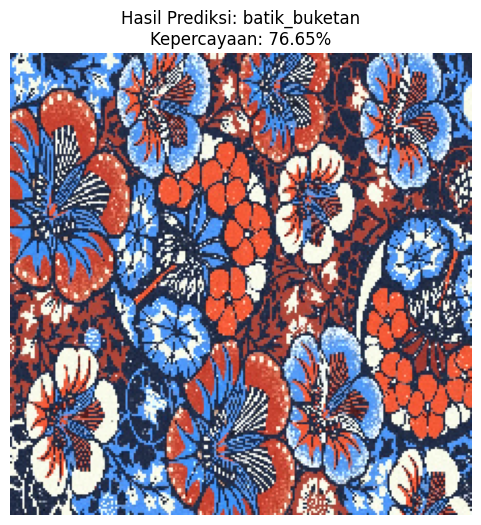


--- 3 Kandidat Terkuat ---
batik_buketan: 76.65%
batik_tribusono: 9.46%
batik_sekarjagad: 4.24%


In [ ]:
# --- BAGIAN 1: DEFINISI FUNGSI (Cukup Jalankan Sekali) ---
def prediksi_batik_baru(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)
    score = predictions[0]
    class_idx = np.argmax(score)
    confidence = 100 * score[class_idx]
    label_prediksi = class_names[class_idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Hasil Prediksi: {label_prediksi}\nKepercayaan: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    print("\n--- 3 Kandidat Terkuat ---")
    top_3_indices = np.argsort(score)[-3:][::-1]
    for i in top_3_indices:
        print(f"{class_names[i]}: {100 * score[i]:.2f}%")

# --- BAGIAN 2: TEMPAT MENEMPELKAN PATH (Ganti di Sini!) ---
# Klik kanan file di folder kiri Colab -> Copy Path -> Paste di antara tanda kutip di bawah ini:

PATH_GAMBAR_SAYA = '/content/test2.jpg'

# --- BAGIAN 3: EKSEKUSI ---
prediksi_batik_baru(PATH_GAMBAR_SAYA)